# Import Libraries

In [2]:
import json
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
import pickle
import re, string
import sys
import seaborn as sns
sns.set()
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
import pickle

# Load the data

`data source`:http://jmcauley.ucsd.edu/data/amazon/

In [5]:
sport = []
for line in open('reviews_Sports_and_Outdoors_5.json', 'r'):
    sport.append(json.loads(line))

In [6]:
df=pd.DataFrame(sport)
df.shape

(296337, 9)

`where`

- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review [2,3], e.g. 2/3 , 2 is numertaor , 3 denominator
  - Numertaor: Number of users who found the review helpful
  - Denominator: Number of users who indicated whether they found the review helpful or not
  - helpfulness of review is defined as the ratio of the number of consumers who found it helpful to the total number of consumers who had read and evaluated the review.
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

In [7]:
# createa a new column which combines review and summary 
df['combined_text'] = df['reviewText'] + ' ' + df['summary']

In [8]:
df.head(2)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,combined_text
0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]",This came in on time and I am veru happy with ...,5.0,Woks very good,1390694400,"01 26, 2014",This came in on time and I am veru happy with ...
1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]",I had a factory Glock tool that I was using fo...,5.0,Works as well as the factory tool,1328140800,"02 2, 2012",I had a factory Glock tool that I was using fo...


# Data Cleaning

In [9]:
# to see if there are any missing values
df.isnull().sum()
# there are some reviewers' names are missing but it is find we can remove that columns,
#we can use reviewers ID 

reviewerID           0
asin                 0
reviewerName      1402
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
combined_text        0
dtype: int64

# EDA


In [10]:
# check how many unique values in rating column
df['overall'].value_counts()

5.0    188208
4.0     64809
3.0     24071
2.0     10204
1.0      9045
Name: overall, dtype: int64

In [11]:
# create a target column based on product_rating, if rating <=3 means bad:0 if rating >=4 good :1
df['target']=[0  if x<=3 else 1 for x in df['overall']]

In [12]:
# create a column for helpfulness Numerator and helpfulness Denominator
df['helpfulness_Numerator']  =[x[0] for x in df['helpful']]
df['helpfulness_Denominator']=[x[1] for x in df['helpful']]

In [13]:
# Double check the data 
df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,combined_text,target,helpfulness_Numerator,helpfulness_Denominator
0,AIXZKN4ACSKI,1881509818,David Briner,"[0, 0]",This came in on time and I am veru happy with ...,5.0,Woks very good,1390694400,"01 26, 2014",This came in on time and I am veru happy with ...,1,0,0
1,A1L5P841VIO02V,1881509818,Jason A. Kramer,"[1, 1]",I had a factory Glock tool that I was using fo...,5.0,Works as well as the factory tool,1328140800,"02 2, 2012",I had a factory Glock tool that I was using fo...,1,1,1
2,AB2W04NI4OEAD,1881509818,J. Fernald,"[2, 2]",If you don't have a 3/32 punch or would like t...,4.0,"It's a punch, that's all.",1330387200,"02 28, 2012",If you don't have a 3/32 punch or would like t...,1,2,2


## Review Counts by Rating

Text(0.5, 1.0, 'Review Counts by Rating')

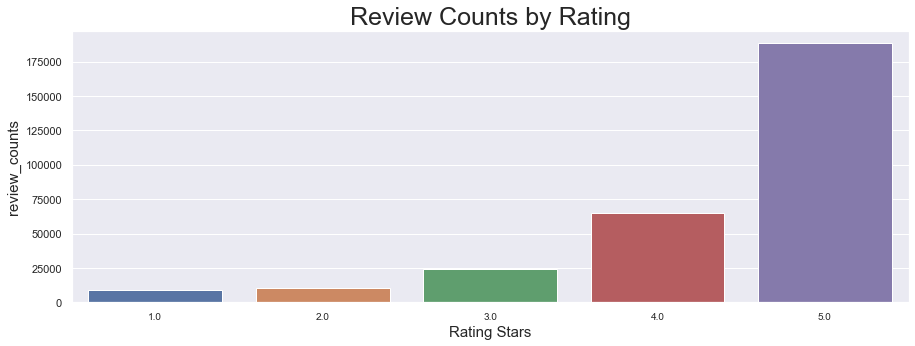

In [16]:
# plot review counts in different rating group
rating=pd.DataFrame(df['overall'].value_counts()).reset_index().sort_values(by='index',ascending=True)
plt.figure(figsize=(15,5))
sns.barplot(rating['index'],rating['overall'])
plt.xticks(fontsize=10)
plt.xlabel('Rating Stars',fontsize=15)
plt.ylabel('review_counts',fontsize=15)
plt.title('Review Counts by Rating',fontsize=25)
# for i in range(len(rating['index'])):
#     plt.text(i+0.9,list(rating['overall'])[::-1][i]+1000,'{}%'.format(round(rating['overall'][i]/sum(rating['overall'])*100,2)),fontsize=15)
# plt.show()

Text(0.5, 1.0, 'Review Counts by Bad/Good Reviews')

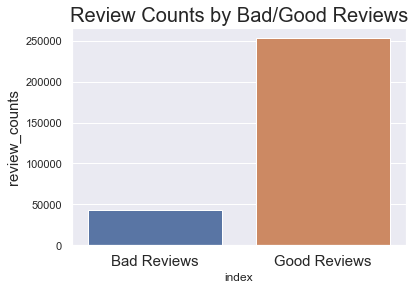

In [17]:
# plot review counts in bad review group and good review group
bad_good=pd.DataFrame(df['target'].value_counts()).reset_index().sort_values(by='index',ascending=False)

sns.barplot(bad_good['index'],bad_good['target'])
plt.xticks([0,1],["Bad Reviews","Good Reviews"],fontsize=15)
plt.ylabel('review_counts',fontsize=15)
plt.title('Review Counts by Bad/Good Reviews',fontsize=20)

## Helpfulness

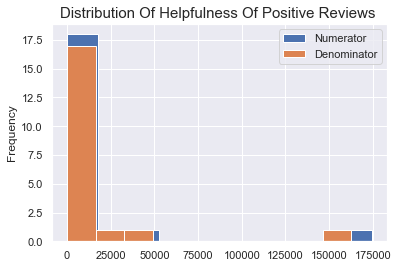

In [19]:
# distribution of helpfulness_Numerator and helpfulness_Denominator in positive reviews
plt.title('distribution of helpfulness of positive Reviews '.title(),fontsize=15)
df[df['target']==1]['helpfulness_Numerator'].value_counts()[:20].plot(kind='hist',label='Numerator')
df[df['target']==1]['helpfulness_Denominator'].value_counts()[:20].plot(kind='hist',label='Denominator')
plt.legend()
plt.show()

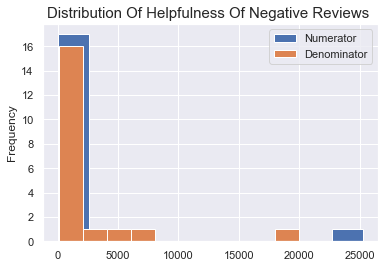

In [20]:
# distribution of helpfulness_Numerator and helpfulness_Denominator in negative reviews
plt.title('distribution of helpfulness of Negative Reviews '.title(),fontsize=15)
df[df['target']==0]['helpfulness_Numerator'].value_counts()[:20].plot(kind='hist',label='Numerator')
df[df['target']==0]['helpfulness_Denominator'].value_counts()[:20].plot(kind='hist',label='Denominator')
plt.legend()
plt.show()

## ReviewTime and target 

In [21]:
import datetime
df['reviewTime'] = pd.to_datetime(df['reviewTime'])

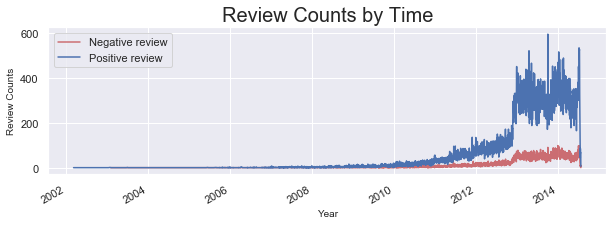

In [22]:
# plot how many products sold from 2003 to 2015
plt.figure(figsize=(10,3))
plt.title('Review Counts by Time',fontsize=20)
plt.ylabel('Review Counts',fontsize=10)
plt.xlabel('Year',fontsize=10)
df[df.target==0]['reviewTime'].value_counts().plot(label='Negative review',color='r',alpha=0.8)
df[df.target==1]['reviewTime'].value_counts().plot(label='Positive review',color='b')
plt.legend()
plt.show()
# In 2013 Amazon sells over 200 million products in the USA, 
#which are categorised into 35 departments and almost 20 million in Sports & Outdoors 

## Products

In [23]:
# let us see in different rating level which products have highest rating - best seller  
# plot the mean of rating for each product and got top 20 in rating :
pd.DataFrame(df.groupby('asin')['overall'].mean()).sort_values(by='overall',ascending=False).iloc[:5]
# 1st :Hydracentials Sporty 25 oz Insulated Stainless Steel Water
# 2nd:Table Tennis Racket Cover 
# 3rd : Drymax Run Mini Crew Socks
# 4th  :MSR Lightning Flotation Tail
# 5th Tiberius Arms First Strike Paintballs (White, 100 Count)


,overall
asin,
B00LFPS0CY,5.0
B003JJW610,5.0
B003EU8G22,5.0
B003EZQ53E,5.0
B003F4WKYW,5.0


In [25]:
# let us see which priducts are the best seller regardless their rating 
best_seller=pd.DataFrame(df['asin'].value_counts()).sort_values(by='asin',ascending=False).iloc[:5]
# 1st Bike
# 2nd Impact Sport OD Green Electric Earmuff  
# 3rd 50 Feet, Black : Rothco 550lb. Type III Nylon Paracord for yoga 
# 4th Survival Bundle - LifeStraw Personal Water Filter AND Magnesium Fire Starter 
# 5th HOPPE'S 24011 BoreSnake Rifle Bore Cleaner, M-16.22-.223 Caliber, 5.56mm
#[' Pistol Magazine Loader','Electric Earmuff','Nylon Paracord for yoga','LifeStraw Water Filter','Rifle Bore Cleaner'])
best_seller

,asin
B001HBHNHE,1042
B001T7QJ9O,763
B000S5ODN2,647
B0010O748Q,513
B0000C50K3,427


## Bigrams before removing stop words

In [26]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
#source:https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

In [27]:
common_words_good = get_top_n_bigram(df[df['target']==1]['combined_text'], 30)
common_words_bad= get_top_n_bigram(df[df['target']==0]['combined_text'], 30)

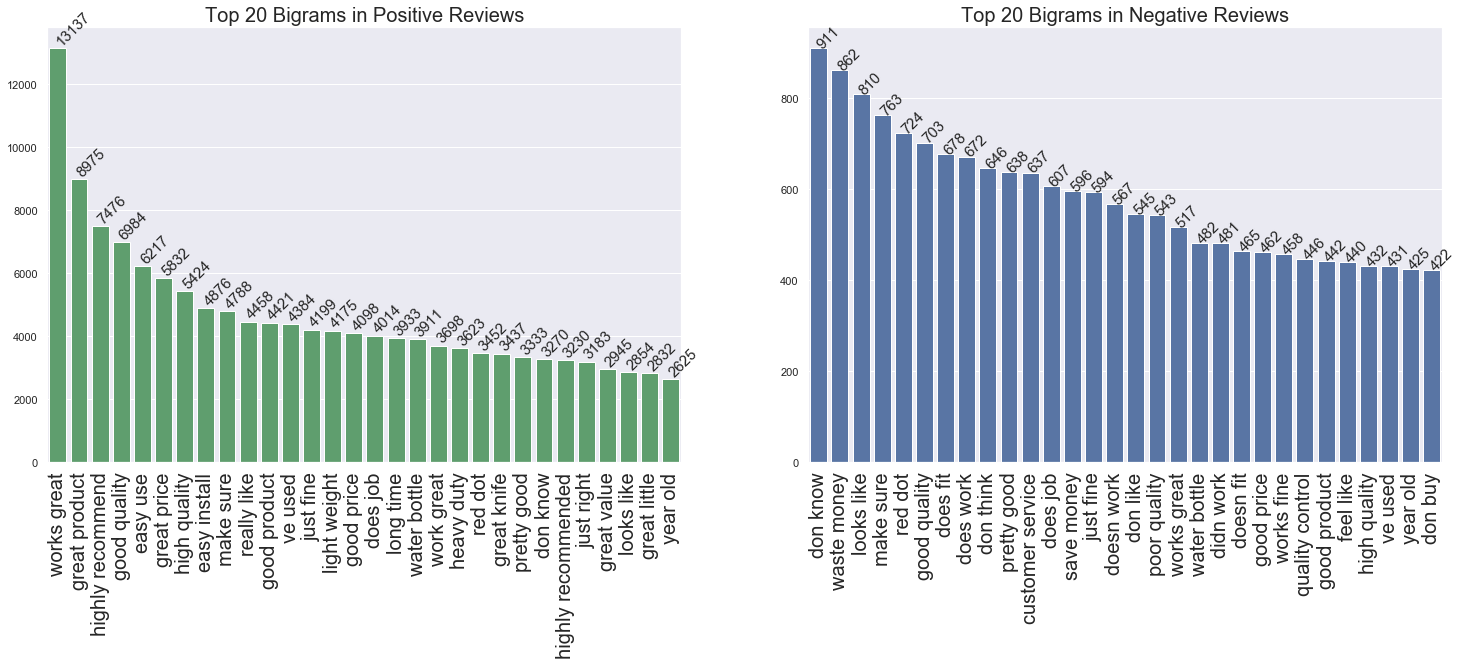

In [28]:
plt.figure(figsize=(25,8))
# good reviews bigrams
plt.subplot(1,2,1)
x_good=[x[0] for x in common_words_good]
y_good=[x[1] for x in common_words_good]
sns.barplot(x_good,y_good,color='g')
plt.xticks(rotation=90,fontsize=20)
plt.title("Top 20 Bigrams in Positive Reviews",fontsize=20)
for i in range(len(x_good)):
    plt.text(i-0.2,y_good[i]+100,'{}'.format(y_good[i]),size=15,rotation=45)
    
plt.subplot(1,2,2)
x_bad=[x[0] for x in common_words_bad]
y_bad=[x[1] for x in common_words_bad]
sns.barplot(x_bad,y_bad,color='b')
plt.xticks(rotation=90,fontsize=20)
plt.title("Top 20 Bigrams in Negative Reviews",fontsize=20)
for i in range(len(x_bad)):
    plt.text(i-0.2,y_bad[i],'{}'.format(y_bad[i]),size=15,rotation=45)


## Trigrams before removing stop words

In [33]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
#source:https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

In [34]:
common_words_good1 = get_top_n_trigram(df[df['target']==1]['combined_text'], 20)
common_words_bad1= get_top_n_trigram(df[df['target']==0]['combined_text'], 20)

In [35]:
pd.DataFrame(common_words_good1).to_csv("common_words_good1.csv")
pd.DataFrame(common_words_bad1).to_csv("common_words_bad1.csv")

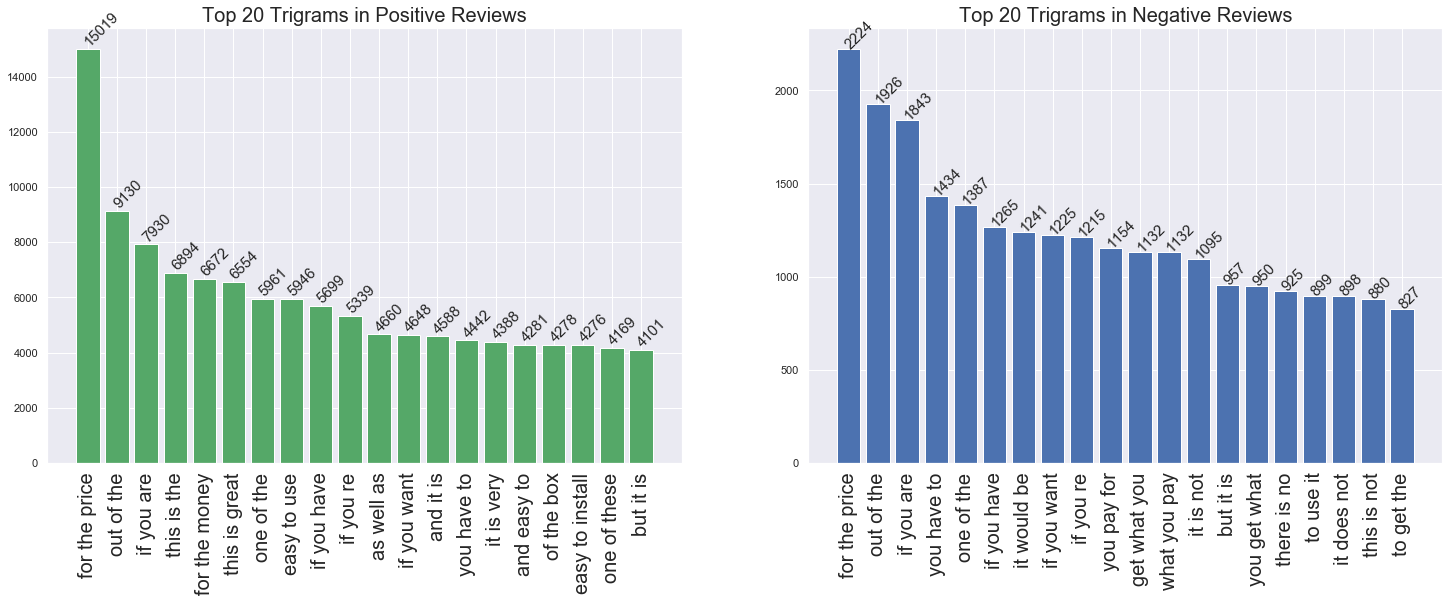

In [36]:
plt.figure(figsize=(25,8))
# good reviews bigrams
plt.subplot(1,2,1)
x_good1=[x[0] for x in common_words_good1]
y_good1=[x[1] for x in common_words_good1]
plt.bar(x_good1,y_good1,color='g')
plt.xticks(rotation=90,fontsize=20)
plt.title("Top 20 Trigrams in Positive Reviews",fontsize=20)
for i in range(len(x_good1)):
    plt.text(i-0.2,y_good1[i]+100,'{}'.format(y_good1[i]),size=15,rotation=45)
    
plt.subplot(1,2,2)
x_bad1=[x[0] for x in common_words_bad1]
y_bad1=[x[1] for x in common_words_bad1]
plt.bar(x_bad1,y_bad1,color='b')
plt.xticks(rotation=90,fontsize=20)
plt.title("Top 20 Trigrams in Negative Reviews",fontsize=20)
for i in range(len(x_bad1)):
    plt.text(i-0.2,y_bad1[i],'{}'.format(y_bad1[i]),size=15,rotation=45)


# Data Preprocessing and more EDA

In [29]:
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘',"'", '©',
'said',"'s", "also",'one',"n't",'com', 'satirewire', '-', '–', 
'—', '_','satirewire.com',"/"]
sw_set = set(sw_list)

In [70]:
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘',"'", '©',
'said',"'s", "also",'one',"n't",'com', 'satirewire', '-', '–', 
'—', '_','satirewire.com',"/"]
sw_set = set(sw_list)

# tokenization
def process_review(review):
    tokens = nltk.word_tokenize(review) # tokenization
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set]# stop workds removal
    return stopwords_removed

# Stemming
from nltk.stem import PorterStemmer
ps = PorterStemmer()
# create a function stemming() and loop through each word in a review
def stemming(review):
    stemmed_review=[]
    for w in review:
        stemmed_review.append(ps.stem(w))
    return stemmed_review

# import libraries
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# create a function  and loop through each word in  a review
def lemmatization(review):
    lemma_list=[]
    for word in review:
        lemma_word=lemmatizer.lemmatize(word,pos='v') 
        lemma_list.append(lemma_word)
    return lemma_list

# Conbime all functions above and obtian cleaned text data 
def data_preprocessing(review):
    #tokenization, stop words removal, punctuation marks removel
    processed_review=list(map(process_review,review))
    # stemming
    stemming_reviews=list(map(stemming,processed_review))
    # lemmatization
    lemma_reviews=list(map(lemmatization,stemming_reviews))
    return lemma_reviews

cleaned_text_data=data_preprocessing(df['combined_text'])

In [33]:
# Conbime all functions above and obtian cleaned text data 
def data_preprocessing(review):
    #tokenization, stop words removal, punctuation marks removel
    processed_review=list(map(process_review,review))
    # stemming
    stemming_reviews=list(map(stemming,processed_review))
    # lemmatization
    lemma_reviews=list(map(lemmatization,stemming_reviews))
    return lemma_reviews

In [34]:
cleaned_text_data=data_preprocessing(df['combined_text'])

In [56]:
# pickle_out=open('cleaned_text_data', 'wb')
# pickle.dump(cleaned_text_data, pickle_out)
# pickle_out.close()

In [80]:
# pickle_in_data = open("cleaned_text_data","rb")
# cleaned_text_data = pickle.load(pickle_in_data)

## Frequency Distributions

In [37]:
# create two  new columns one for filtered_review , one for review length
df['filtered_review']=cleaned_text_data
df['review_len']=[len(x) for x in df['filtered_review']]

In [38]:
# obtian the bad reviews and good reviews data and w
badreviews =df[df.overall<=3.0]['filtered_review']
goodreviews = df[df.overall>=4.0]['filtered_review']

In [39]:
from itertools import chain
#pd.DataFrame(pd.Series(chain(*goodreviews)).value_counts())
bad_re=pd.DataFrame(pd.Series(chain(*badreviews)).value_counts()).sort_values(by=0,ascending=False).reset_index()
good_re=pd.DataFrame(pd.Series(chain(*goodreviews)).value_counts()).sort_values(by=0,ascending=False).reset_index()

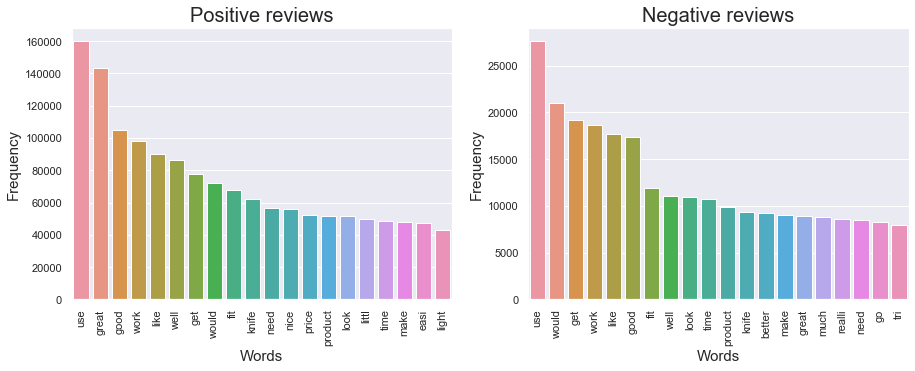

In [40]:
# Most common words in good reviews and bad reviews
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(good_re['index'][:20],good_re[0][:20])
plt.xticks(rotation=90)
plt.title('Positive reviews',fontsize=20)
plt.xlabel('Words',fontsize=15)
plt.ylabel('Frequency',fontsize=15)

plt.subplot(1,2,2)
sns.barplot(bad_re['index'][:20],bad_re[0][:20])
plt.xticks(rotation=90)
plt.title('Negative reviews',fontsize=20)
plt.xlabel('Words',fontsize=15)
plt.ylabel('Frequency',fontsize=15)


plt.show()


## Review Length and Rating 

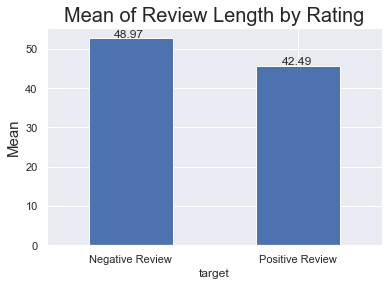

In [41]:
df.groupby('target')['review_len'].mean().plot(kind='bar',color='b')
plt.ylabel('Mean',fontsize=15)
plt.xticks([0,1],['Negative Review','Positive Review'],rotation=0)
plt.title('Mean of Review Length by Rating',fontsize=20)
plt.text(0-0.1,53,'48.97')
plt.text(1-0.1,46,'42.49')
plt.show()
# it makes sense the mean length of negative review is longer than positive reviews
# 1, if people are not satisfied with the product they will speak a lot with their compaint
#2, people they satisfied or feel okey with the prduct they might not writing any reviews and the rating
# will automatically become positive score or 
# will just say something " good and well or I love it and like it"


Mean of review length for nagative reviews and positive reviews are similary which is around 45.

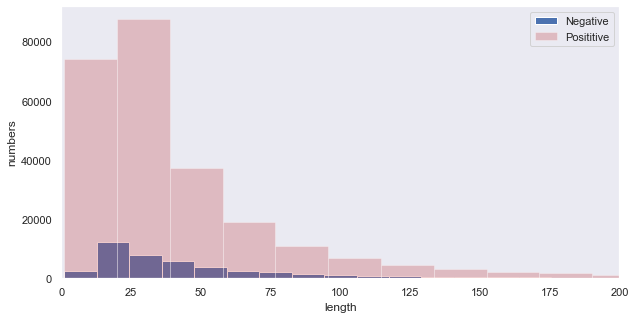

In [42]:
#overall 
plt.rcParams['figure.figsize'] = (10, 5)
bins = 150
plt.hist(df[df['target'] == 0]['review_len'], alpha = 1,color='b' ,bins=bins, label='Negative')
plt.hist(df[df['target'] == 1]['review_len'], alpha = 0.3, color='r',bins=bins, label='Posititive')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,200)
plt.grid()
plt.show()

## Word Clouds

In [43]:
common_words_good=pd.read_csv('common_words_good.csv')
common_words_bad=pd.read_csv('common_words_bad.csv')
common_words_good.columns

Index(['Unnamed: 0', '0', '1'], dtype='object')

In [44]:
# create dictinary for good review and bad review 
good_re_dictionary={}
for i in range(len(common_words_good)):
    good_re_dictionary[common_words_good['0'][i]]=common_words_good['1'][i]
    
bad_re_dictionary={}
for i in range(len(common_words_bad)):
    bad_re_dictionary[common_words_bad['0'][i]]=common_words_bad['1'][i]

In [45]:
# wordcloud function
from wordcloud import WordCloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

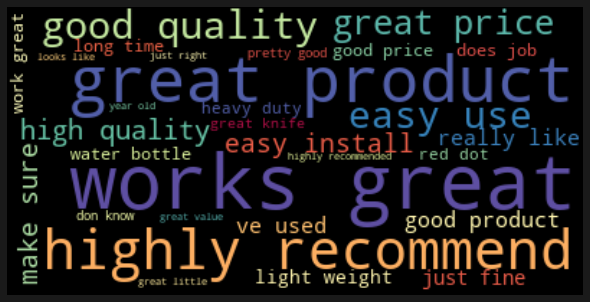

In [46]:
# Create the word cloud of Positive Reviews
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(good_re_dictionary)
plt.figure(figsize=(8,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

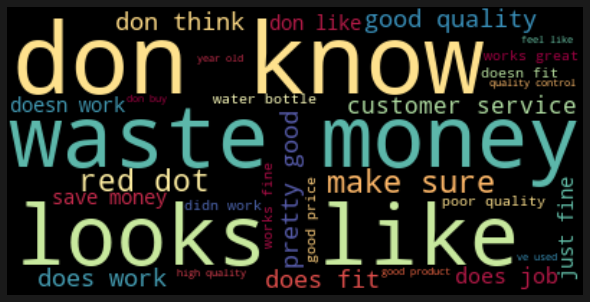

In [47]:
# Create the word cloud of Negative reviews
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(bad_re_dictionary)
plt.figure(figsize=(8,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Helpfulness and reviewtext

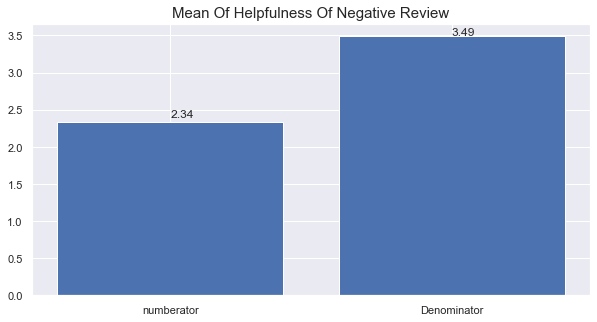

In [48]:
numer_0= df[df['target']==0]['helpfulness_Numerator'].mean()
deno_0=df[df['target']==0]['helpfulness_Denominator'].mean()
plt.bar(['numberator','Denominator'],[numer_0,deno_0])
plt.text(0,2.4,round(numer_0,2))
plt.text(1,3.5,round(deno_0,2))
plt.title('Mean of helpfulness of Negative review'.title(),fontsize=15)
plt.show()

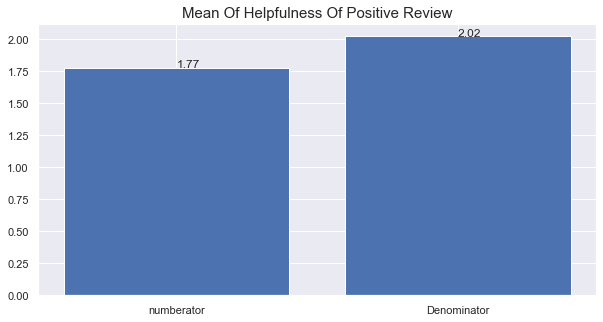

In [49]:
numer_1= df[df['target']==1]['helpfulness_Numerator'].mean()
deno_1=df[df['target']==1]['helpfulness_Denominator'].mean()
plt.bar(['numberator','Denominator'],[numer_1,deno_1])
plt.text(0,1.78,round(numer_1,2))
plt.text(1,2.02,round(deno_1,2))
plt.title('Mean of helpfulness of Positive review'.title(),fontsize=15)
plt.show()

In [50]:
# pickle_out=open('df', 'wb')
# pickle.dump(df, pickle_out)
# pickle_out.close()

In [2]:
pickle_in_data = open("df","rb")
df = pickle.load(pickle_in_data)

In [3]:
df=pd.read_csv('/Users/yingyuxuan/Desktop/nyc-mhtn-ds-010620-lectures/Final_Project/Final_project/data/df.csv')

# Train Test Split

In [4]:
#declare inputs and target
inputs=df[['filtered_review','unixReviewTime','helpfulness_Numerator', 'helpfulness_Denominator','review_len']]
target=df['target']

In [5]:
#train test split dataset 
x_train, x_test, y_train, y_test = train_test_split(inputs, target, test_size=.2, random_state=0)

In [6]:
# join all strings together for each row 
review_train=pd.DataFrame(data=[' '.join(x) for x in x_train['filtered_review']])
review_test=pd.DataFrame(data=[' '.join(x) for x in x_test['filtered_review']])

# Resampling 

In [7]:
from sklearn.utils import resample

In [8]:
# concatenate our training data back together
training  = pd.DataFrame()
training[list(x_train.columns)]=x_train
training['target']=y_train
training.head()

,filtered_review,unixReviewTime,helpfulness_Numerator,helpfulness_Denominator,review_len,target
275333,"['light', 'held', 'glock', 'round', 'protrud',...",1403913600,0,0,44,1
258272,"['repons', 'effect', 'time', 'excel', 'product...",1350000000,1,2,14,1
124048,"['wish', 'youtub', 'video', 'advertis', 'knife...",1375401600,1,1,39,1
107684,"['say', 'amaz', 'product', 'wet', 'put', 'arou...",1312675200,2,2,33,1
255706,"['let', 'start', 'write', 'great', 'target', '...",1365206400,0,0,43,1


In [9]:
# separate minority and majority classes
negative_review= training[training.target==0]
positive_review= training[training.target==1]


In [10]:
# Get a class count to understand the class imbalance.
print('negative review count: '+ str(len(negative_review)))
print('positive review count: '+ str(len(positive_review)))

negative review count: 34606
positive review count: 202463


In [11]:
# upsample minority
negative_upsampled = resample(negative_review,
                          replace=True, # sample with replacement
                          n_samples=len(positive_review), # match number in majority class
                          random_state=23) # reproducible results
negative_upsampled.head()

,filtered_review,unixReviewTime,helpfulness_Numerator,helpfulness_Denominator,review_len,target
89050,"['expect', 'someth', 'nice', 'right', 'box', '...",1378080000,1,1,35,0
37954,"['well', 'everi', 'sk', 'bit', 'differ', 'ga',...",1287273600,5,7,48,0
85511,"['product', 'deliv', 'pretti', 'sure', 'could'...",1391558400,0,0,24,0
52064,"['grip', 'kind', 'univers', 'fit', 'specif', '...",1365120000,0,0,18,0
36807,"['review', 'cheap', 'glass', 'remington', 'may...",1364342400,4,12,72,0


In [12]:
# combine majority and upsampled minority
upsampled= pd.concat([positive_review, negative_upsampled])

# check new class counts
upsampled.target.value_counts()

1    202463
0    202463
Name: target, dtype: int64

In [13]:
y_train = upsampled.target
x_train = upsampled.drop('target', axis=1)

In [14]:
x_train.head()

,filtered_review,unixReviewTime,helpfulness_Numerator,helpfulness_Denominator,review_len
275333,"['light', 'held', 'glock', 'round', 'protrud',...",1403913600,0,0,44
258272,"['repons', 'effect', 'time', 'excel', 'product...",1350000000,1,2,14
124048,"['wish', 'youtub', 'video', 'advertis', 'knife...",1375401600,1,1,39
107684,"['say', 'amaz', 'product', 'wet', 'put', 'arou...",1312675200,2,2,33
255706,"['let', 'start', 'write', 'great', 'target', '...",1365206400,0,0,43


Neural Network is slightly better than other models. Neural Network will be the final model for non_text data.

# Generating the Base First-Level Models

model stacking methond source: 
- https://www.kdnuggets.com/2017/02/stacking-models-imropved-predictions.html
- https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
- https://medium.com/@dan.j.izquierdo/an-ensemble-of-sklearners-quick-intro-to-model-stacking-e1a6a37600b0

## Vectorizing  Text Data

In [15]:
from sklearn.feature_extraction.text import CountVectorizer 

In [19]:
train_text=["".join(x) for x in x_train['filtered_review']]
test_text=["".join(x) for x in x_test['filtered_review']]

In [21]:
vectorizer=CountVectorizer()

In [22]:
X_trainc=vectorizer.fit_transform(train_text)
X_testc=vectorizer.transform(test_text)

## Modeling

- Naive Bayes Classifier
- Neural NetWork
- Logistic Regression

### Naive Bayes Classifier

In [23]:
from sklearn.model_selection import GridSearchCV
def NB_GridSearch(X_train, y_train):
    grid_params = {'alpha':[0.1,0.2,0.3,0.4,0.5],
                     'fit_prior': [True, False],  }

    gs = GridSearchCV( MultinomialNB(), grid_params,scoring='f1')
    gs.fit(X_train, y_train)
    print("Best Score: ", gs.best_score_)
    return gs.best_params_.values()

In [24]:
def NaiveBayes(X_train,y_train,X_test,y_test,alpha,fit_prior):
    # fit the training dataset on the NB classifier
    Naive = MultinomialNB(alpha=0.1, fit_prior= True)
    Naive.fit(X_train,y_train)
    #prediction
    nb_train_pre=Naive.predict(X_train)
    nb_test_pre=Naive.predict(X_test)
    # Use accuracy_score function to get the accuracy
    print("Naive Bayes Train Accuracy Score :",accuracy_score(nb_train_pre, y_train))
    print("Naive Bayes Test Accuracy Score :",accuracy_score(nb_test_pre, y_test))
    # calculate f1 scores for test data and train data 
    nb_f1_score_test=f1_score(y_test,nb_test_pre)
    nb_f1_score_train=f1_score(y_train,nb_train_pre)

    print("Train data f1 score:{}".format(nb_f1_score_train))
    print("Test data f1 score:{}".format(nb_f1_score_test ))
    print("confusion_matrix:{}".format(confusion_matrix(y_test, nb_test_pre)))
    return nb_train_pre,nb_test_pre

In [25]:
alpha1,fit_prior1=NB_GridSearch(X_trainc, y_train)

Best Score:  0.8327775132083037


In [26]:
nb_train_prec,nb_test_prec=NaiveBayes(X_trainc,y_train,X_testc,y_test,alpha1,fit_prior1)

Naive Bayes Train Accuracy Score : 0.8423909553844406
Naive Bayes Test Accuracy Score : 0.8315785921576567
Train data f1 score:0.8465127465127466
Test data f1 score:0.8959839943313257
confusion_matrix:[[ 6294  2420]
 [ 7562 42992]]


### Neural NetWork

In [27]:
# thanks to :https://realpython.com/python-keras-text-classification/
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD
import tensorflow as tf


Using TensorFlow backend.


In [29]:
from keras import regularizers
import random
def history_model(X_train, y_train,X_test, y_test):
    #Before we build our model, we need to know the input dimension of our feature vectors.
    input_dim = X_train.shape[1] 
    # Add layers one by one in order 
    random.seed(123)
    model = Sequential()
    model.add(keras.layers.Dense(10, input_dim=input_dim, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    opt = SGD(lr=0.01, momentum=0.9)
    #specify the optimizer and the loss function.
    model.compile(loss='binary_crossentropy', 
                  optimizer=opt, 
                  metrics=['accuracy'])

    #Give an overview of the model and the number of parameters available for training:
    model.summary()
    # # fit the model
    history = model.fit(X_train, y_train,epochs=50, verbose=1,
                    validation_data=(X_test, y_test),batch_size=70)
    return history, model

In [30]:
def nn_result_prediction(X_train, y_train,X_test, y_test,model):
    # obtian Accuracies for train data and test data
    loss1, accuracy1 = model.evaluate(X_train, y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy1))
    loss2, accuracy2 = model.evaluate(X_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy2))
    #prediction
    nn_train_pre=model.predict_classes(X_train)
    nn_test_pre=model.predict_classes(X_test)

    # calculate f1 scores for test data and train data 
    nn_f1_score_test=f1_score(y_test,nn_test_pre)
    nn_f1_score_train=f1_score(y_train,nn_train_pre)

    print("Train data f1 score:{}".format(nn_f1_score_train))
    print("Test data f1 score:{}".format(nn_f1_score_test ))
    print("confusion_matrix:{}".format(confusion_matrix(y_test, nn_test_pre)))
    return nn_train_pre,nn_test_pre

In [57]:
historyc, modelc=history_model(X_trainc, y_train,X_testc, y_test)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                688600    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 688,611
Trainable params: 688,611
Non-trainable params: 0
_________________________________________________________________
Train on 404926 samples, validate on 59268 samples
Epoch 1/50
404926/404926 [==============================] - 349s 863us/step - loss: 0.4031 - accuracy: 0.8213 - val_loss: 0.3581 - val_accuracy: 0.8407
Epoch 2/50
404926/404926 [==============================] - 361s 892us/step - loss: 0.3405 - accuracy: 0.8508 - val_loss: 0.3719 - val_accuracy: 0.8333
Epoch 3/50
404926/404926 [==============================] - 358s 884us/step - loss: 0.3102 - accuracy: 0.8684 - val_loss: 0.3421 - val_accuracy: 0.8526
Epo

404926/404926 [==============================] - 415s 1ms/step - loss: 0.0691 - accuracy: 0.9772 - val_loss: 0.9997 - val_accuracy: 0.8572
Epoch 50/50
404926/404926 [==============================] - 422s 1ms/step - loss: 0.0694 - accuracy: 0.9770 - val_loss: 1.0217 - val_accuracy: 0.8437


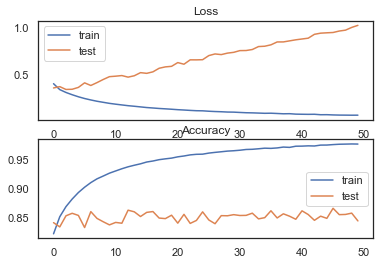

In [58]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(historyc.history['loss'], label='train')
plt.plot(historyc.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(historyc.history['accuracy'], label='train')
plt.plot(historyc.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [59]:
# create a function to show the resunlts
from sklearn.metrics import confusion_matrix

def nn_result_prediction(X_train, y_train,X_test, y_test,model): 
    #prediction
    nn_train_pre=model.predict_classes(X_train)
    nn_test_pre=model.predict_classes(X_test)
    # calculate f1 scores for test data and train data 
    nn_f1_score_test=f1_score(y_test,nn_test_pre)
    nn_f1_score_train=f1_score(y_train,nn_train_pre)
    print("Train data f1 score:{}".format(nn_f1_score_train))
    print("Test data f1 score:{}".format(nn_f1_score_test ))
    
    print("confusion_matrix:{}".format(confusion_matrix(y_test, nn_test_pre)))

    return nn_train_pre,nn_test_pre

In [60]:
# using the function above to show the result
nn_train_prec,nn_test_prec=nn_result_prediction(X_trainc, y_train,X_testc, y_test,modelc)

Train data f1 score:0.9757375538184486
Test data f1 score:0.9059686799078464
confusion_matrix:[[ 5370  3344]
 [ 5921 44633]]


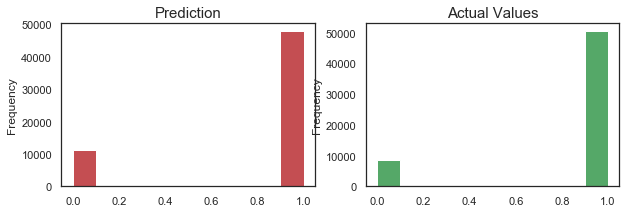

In [61]:
# figure size 
plt.figure(figsize=(10,3))
# subplot for prediction
plt.subplot(1,2,1)
pd.Series([x[0] for x in nn_test_prec]).plot(kind='hist',color='r')
plt.title('Prediction',fontsize=15)
# subplot for actual values 
plt.subplot(1,2,2)
y_test.plot(kind='hist',color='g')
plt.title('Actual Values',fontsize=15)

plt.show()

### Logistic regression

In [32]:
#import Logistic Regression
from sklearn.linear_model import LogisticRegression

def Logistic_Regression(X_train, y_train,X_test, y_test):
    log_re = LogisticRegression(max_iter=1000)
    log_re.fit(X_train, y_train)
    #calculate scores for test data and train data 
    test_data_score = log_re.score(X_test, y_test)
    train_data_score = log_re.score(X_train, y_train)
    print("Train data score:{}".format(train_data_score ))
    print("Test data score:{}".format(test_data_score ))
    # predict values for test data and train data
    log_y_test_pre=log_re.predict(X_test)
    log_y_train_pre=log_re.predict(X_train)
    # calculate f1 scores for test data and train data 
    log_f1_score_test=f1_score(y_test,log_y_test_pre)
    log_f1_score_train=f1_score(y_train,log_y_train_pre)

    print("Train data f1 score:{}".format(log_f1_score_train))
    print("Test data f1 score:{}".format(log_f1_score_test ))
    return log_y_train_pre,log_y_test_pre

In [33]:
log_y_train_prec,log_y_test_prec=Logistic_Regression(X_trainc, y_train,X_testc, y_test)

Train data score:0.8905725984500872
Test data score:0.8452790713369778
Train data f1 score:0.8902995162384444
Test data f1 score:0.9048360315483602


In [98]:
# compare all the models 
# f1_Score of each model has no big difference. 
# Logistic Regression model gives the best result
ME=pd.DataFrame()
ME['Model']=['Navie Bayes','Neural Network','Logistic Regression',]
ME['f1_score']=[0.8959,0.9059,0.9048]
ME

,Model,f1_score
0,Navie Bayes,0.8959
1,Neural Network,0.9059
2,Logistic Regression,0.9048


# Frist-Level Predictions for non_text data

##  Standardization for Numerical data 

In [34]:
#import library for data standardization
from sklearn.preprocessing import StandardScaler

x_train_numer=x_train[['unixReviewTime', 'helpfulness_Numerator','helpfulness_Denominator', 'review_len']]
x_test_numer=x_test[['unixReviewTime', 'helpfulness_Numerator','helpfulness_Denominator', 'review_len']]

scaler = StandardScaler()  
scaler.fit(x_train_numer)

X_train_numer = scaler.transform(x_train_numer)  
X_test_numer = scaler.transform(x_test_numer)  

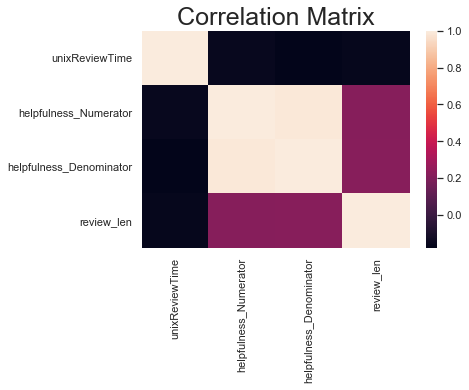

In [35]:
# correlation matrix
X_train_cor=pd.DataFrame(data=X_train_numer, columns=x_train_numer.columns)
sns.set(style="white")
sns.heatmap(X_train_cor.corr())
plt.title("correlation matrix".title(),fontsize=25)
plt.show()

## Modeling for numerical data 
- Random Forest
- Logistic Regression
- Neural Network

### Random Forest 

In [62]:
from sklearn.model_selection import RandomizedSearchCV

In [63]:
# given prameters different values
random_grid={
             'n_estimators':list(range(400,500,10))
#              'max_depth':list(range(1,30,2)),
#               'max_features':list(range(1,5)),
#              'min_samples_leaf':list(range(1,23,2)),
#               'min_samples_split':list(range(2,21,2))                
             }
# random forest model
rf=RandomForestClassifier(n_jobs=-1,  random_state=0)

In [64]:
# randommized searchCV
RS=RandomizedSearchCV(rf,random_grid,cv=5,scoring="f1")

In [67]:
# fit the train data
RS.fit(X_train_numer,list(y_train)) 

In [ ]:
# obtian best parameters best score
RS.best_score_,RS.best_params_ 

In [41]:
rfc=RandomForestClassifier(n_estimators=480,
                           max_depth=11, 
                           min_samples_leaf=11,
                           min_samples_split= 2,
                           n_jobs=-1,  random_state=0)

In [42]:
rfc.fit(X_train_numer,list(y_train))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=11, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=480,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [43]:
# Score for train and test data 
print("Score of train data :" ,rfc.score(X_train_numer,y_train))
print("Score of test data :" ,rfc.score(X_test_numer,y_test))

Score of train data : 0.6475479470322972
Score of test data : 0.7099615306742255


In [44]:
rf_num_train_pre=rfc.predict(X_train_numer)
rf_num_test_pre=rfc.predict(X_test_numer)
f1_score_numer_train=f1_score(list(y_train),rf_num_train_pre)
f1_score_numer_test=f1_score(list(y_test),rf_num_test_pre)

In [45]:
print("F1 Score of train data :" , f1_score_numer_train)
print("F1 Score of test data :" ,f1_score_numer_test)

F1 Score of train data : 0.6835044984908932
F1 Score of test data : 0.8156054234960953


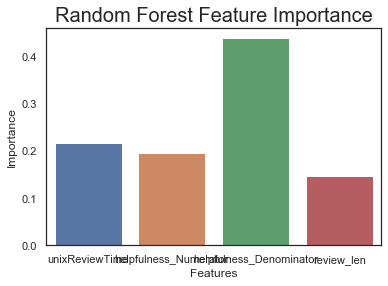

In [46]:
sns.barplot(x_train_numer.columns,rfc.feature_importances_)
plt.title('Random Forest Feature Importance',fontsize=20)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

### Logistic Regression

In [47]:
#import Logistic Regression
from sklearn.linear_model import LogisticRegression
log_regression = LogisticRegression()
log_regression.fit(X_train_numer, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
#calculate scores for test data and train data 
test_num_data_score = log_regression.score(X_test_numer, y_test)
train_num_data_score = log_regression.score(X_train_numer, y_train)
print("Train data score:{}".format(train_num_data_score ))
print("Test data score:{}".format(test_num_data_score ))

Train data score:0.6121661735724552
Test data score:0.7798812175204157


In [49]:
# predict values for test data and train data
logistic_num_test_pre=log_regression.predict(X_test_numer)
logistic_num_train_pre=log_regression.predict(X_train_numer)
# calculate f1 scores for test data and train data 
logistic_f1_score_num_test=f1_score(y_test,logistic_num_test_pre)
logistic_f1_score_num_train=f1_score(y_train,logistic_num_train_pre)

print("Train data f1 score:{}".format(logistic_f1_score_num_train))
print("Test data f1 score:{}".format(logistic_f1_score_num_test ))

Train data f1 score:0.6867352597374101
Test data f1 score:0.8680809755900256


### Neural Network

In [50]:
#Before we build our model, we need to know the input dimension of our feature vectors.
input_num_dim = X_train_numer.shape[1] 
input_num_dim
# Add layers one by one in order 
model_num = Sequential()
model_num.add(keras.layers.Dense(10, input_dim=input_num_dim, activation='relu'))
model_num.add(keras.layers.Dense(1, activation='sigmoid'))
opt = SGD(lr=0.01, momentum=0.9)


#specify the optimizer and the loss function.
model_num.compile(loss='binary_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])

#Give an overview of the model and the number of parameters available for training:
model_num.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [52]:
# fit the model
history_num = model_num.fit(X_train_numer, y_train,epochs=50, verbose=1,
                    validation_data=(X_test_numer, y_test),batch_size=70)

Train on 404926 samples, validate on 59268 samples
Epoch 1/50
404926/404926 [==============================] - 17s 41us/step - loss: 0.6439 - accuracy: 0.6128 - val_loss: 0.6398 - val_accuracy: 0.7144
Epoch 2/50
404926/404926 [==============================] - 22s 53us/step - loss: 0.6439 - accuracy: 0.6131 - val_loss: 0.6564 - val_accuracy: 0.6815
Epoch 3/50
404926/404926 [==============================] - 23s 58us/step - loss: 0.6437 - accuracy: 0.6132 - val_loss: 0.6105 - val_accuracy: 0.7810
Epoch 4/50
404926/404926 [==============================] - 18s 44us/step - loss: 0.6439 - accuracy: 0.6128 - val_loss: 0.6217 - val_accuracy: 0.7823
Epoch 5/50
404926/404926 [==============================] - 18s 46us/step - loss: 0.6437 - accuracy: 0.6132 - val_loss: 0.6219 - val_accuracy: 0.7580
Epoch 6/50
404926/404926 [==============================] - 18s 45us/step - loss: 0.6436 - accuracy: 0.6132 - val_loss: 0.6273 - val_accuracy: 0.7576
Epoch 7/50
404926/404926 [=======================

In [55]:
# obtian Accuracies for train data and test data
loss_num_train, accuracy_num_train = model_num.evaluate(X_train_numer, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_num_train))
loss_num_test, accuracy_num_test = model_num.evaluate(X_test_numer, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy_num_test))

Training Accuracy: 0.6138
Testing Accuracy:  0.7761


In [56]:
#prediction
nn_num_train_pre=model_num.predict_classes(X_train_numer)
nn_num_test_pre=model_num.predict_classes(X_test_numer)
# calculate f1 scores for test data and train data 
nn_f1_score_num_test=f1_score(y_test,nn_num_test_pre)
nn_f1_score_num_train=f1_score(y_train,nn_num_train_pre)

print("Train data f1 score:{}".format(nn_f1_score_num_train))
print("Test data f1 score:{}".format(nn_f1_score_num_test ))

Train data f1 score:0.6862391432142707
Test data f1 score:0.8653584691247793


## Model evaluation

In [97]:
# f1_Score of each model has no big difference. 
# Logistic Regression model gives the best result
ME1=pd.DataFrame()
ME1['Model']=['Random Forest','Logistic Regression','Neural Network']
ME1['f1_score']=[f1_score_numer_test,logistic_f1_score_num_test,nn_f1_score_num_test]
ME1

,Model,f1_score
0,Random Forest,0.815605
1,Logistic Regression,0.868081
2,Neural Network,0.865358


# Second-Level Predictions from the First-level Output


## First-level output as new features


Having now obtained the first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

In [89]:
x_train2 = pd.DataFrame( {
    
     'Naive_Bayes_1': nb_train_prec.ravel(),
     'Neural_Network1': nn_train_prec.ravel(),
     'Logistic_Regression1': log_y_train_prec.ravel(),
     'Random_Forest2': rf_num_train_pre.ravel(),
     'Logistic_Regression2':logistic_num_train_pre.ravel(),
    'Neural_Network2':nn_num_train_pre.ravel()
                                        
    })

x_train2.head()

,Naive_Bayes_1,Neural_Network1,Logistic_Regression1,Random_Forest2,Logistic_Regression2,Neural_Network2
0,1,1,1,0,1,0
1,1,1,1,0,0,0
2,1,0,1,0,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1


In [90]:
x_test2 = pd.DataFrame( {
    
     'Naive_Bayes_1': nb_test_prec.ravel(),
     'Neural_Network1': nn_test_prec.ravel(),
     'Logistic_Regression1': log_y_test_prec.ravel(),
     'Random_Forest2': rf_num_test_pre.ravel(),
     'Logistic_Regression2':logistic_num_test_pre.ravel(),
    'Neural_Network2':nn_num_test_pre.ravel()
                                        })

x_test2.head()

,Naive_Bayes_1,Neural_Network1,Logistic_Regression1,Random_Forest2,Logistic_Regression2,Neural_Network2
0,1,1,1,1,1,1
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,0,0,0,0,0,0
4,1,0,1,1,1,1


## Correlation Heatmap of the Second Level Training set

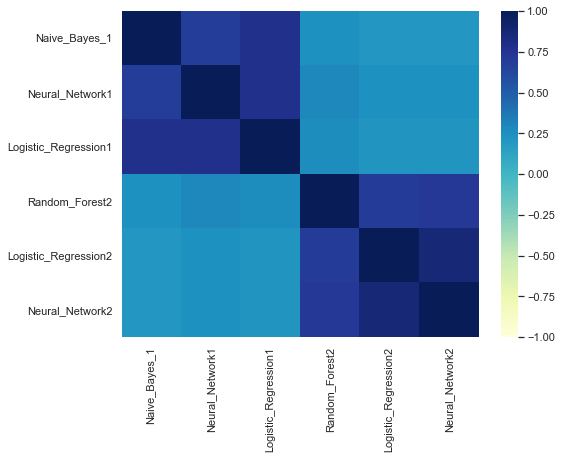

In [91]:
plt.figure(figsize=(8,6))
sns.heatmap(x_train2.corr(),vmin=-1,cmap='YlGnBu')

## Modeling

### XGboost

In [92]:
import xgboost as xgb

In [94]:
# given prameters different values
Random_Grid={
             'n_estimators':list(range(50,500,50)),
               'max_depth':list(range(1,30,2)),
              'max_features':list(range(1,5)),
             'min_samples_leaf':list(range(1,23,2)),
              'min_samples_split':list(range(2,21,2))                
             }


In [ ]:
# xgboost  model
gbm = xgb.XGBClassifier(  max_depth= 27,
                          n_estimators=400,
                         n_jobs=-1,  
                         random_state=0)
# randommized searchCV
rs=RandomizedSearchCV(gbm,Random_Grid,cv=5,scoring="f1")

In [189]:
# fit the train data
rs.fit(x_train2,list(y_train)) 

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=400,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='d

In [192]:
# obtian best parameters best score
rs.best_score_,rs.best_params_ 

(0.9985557061142603, {'max_depth': 27})

In [95]:

GBM = xgb.XGBClassifier(max_depth= 27,
                        n_estimators=400,
                        n_jobs=-1,  
                        random_state=0)
# fit the model 
GBM.fit(x_train2, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=27,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [96]:
#predictions
train_pre=GBM.predict(x_train2)
test_pre=GBM.predict(x_test2)
# obtian f1 score
f1_score_train=f1_score(list(y_train),train_pre)
f1_score_test=f1_score(list(y_test),test_pre)
# Score for train and test data 
print("F1 Score of train data :" , f1_score_train)
print("F1 Score of test data :" ,f1_score_test)

F1 Score of train data : 0.9758024122455521
F1 Score of test data : 0.906148538961039


### Neural Network 

In [99]:
# simply use the funtions created before 
history2, model2=history_model(x_train2, y_train,x_test2, y_test)
nn_train_pre2,nn_test_pre2=nn_result_prediction(x_train2, y_train,x_test2, y_test,model2)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 10)                70        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
Train on 404926 samples, validate on 59268 samples
Epoch 1/50
404926/404926 [==============================] - 17s 42us/step - loss: 0.1038 - accuracy: 0.9740 - val_loss: 0.5228 - val_accuracy: 0.8437
Epoch 2/50
404926/404926 [==============================] - 17s 41us/step - loss: 0.0975 - accuracy: 0.9761 - val_loss: 0.5274 - val_accuracy: 0.8437
Epoch 3/50
404926/404926 [==============================] - 15s 37us/step - loss: 0.0975 - accuracy: 0.9761 - val_loss: 0.5208 - val_accuracy: 0.8437
Epoch 4/50
404926/4

404926/404926 [==============================] - 26s 65us/step - loss: 0.0968 - accuracy: 0.9761 - val_loss: 0.5214 - val_accuracy: 0.8442
Train data f1 score:0.9757762419871795
Test data f1 score:0.9063523779578673
confusion_matrix:[[ 5355  3359]
 [ 5874 44680]]


# Final Model evalueation

In [102]:
# before model stacking - TEXT DATA and NN has highest F1 score 
ME

,Model,f1_score
0,Navie Bayes,0.8959
1,Neural Network,0.9059
2,Logistic Regression,0.9048


In [103]:
# before model stacking - NONE-TEXT DATA
ME1

,Model,f1_score
0,Random Forest,0.815605
1,Logistic Regression,0.868081
2,Neural Network,0.865358


In [104]:
#After Model stacking 
#Compaire xgboost and NN f1 score  and both of them are same also 
print("F1 Score of Xgboost        :" , f1_score(y_test,test_pre))
print("F1 Score of Neural Network :" ,f1_score(y_test,nn_test_pre2))

F1 Score of Xgboost        : 0.906148538961039
F1 Score of Neural Network : 0.9063523779578673


We can see that after model stacking the f1 score increased from 0.9059(NN) to 0.9063(NN)